In [1]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

# Initialize video capture
cap = cv2.VideoCapture(0)

# Variables for counting repetitions and tracking stage
counter = 0
stage = None

# Threshold for elbow movement stability
elbow_movement_threshold = 0.01
prev_elbow_position = None

# Data storage for evaluations
angle_data = []
stability_data = []
reps_data = []

# Feedback function for angle and elbow stability
def feedback(angle, elbow_position, prev_elbow_position):
    # Calculate elbow movement
    movement = np.linalg.norm(np.array(elbow_position) - np.array(prev_elbow_position)) if prev_elbow_position is not None else 0
    
    # Elbow stability feedback
    elbow_feedback = "Elbow stability: Good"
    if movement > elbow_movement_threshold:
        elbow_feedback = "Elbow is moving too much! Please stabilize."
        return movement, elbow_feedback, "Form: Not good"

    # Angle feedback for correct form
    angle_feedback = ""
    if angle > 160:
        angle_feedback = "Curl up (bring the weight up)."
    elif angle < 30:
        angle_feedback = "Go down (lower the weight)."
    elif 30 <= angle <= 160:
        angle_feedback = "Good form! Keep going."
    
    return movement, elbow_feedback, angle_feedback

# Loop to capture video and analyze pose
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    # Convert image back to BGR for rendering
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark

        # Extract the elbow, shoulder, and wrist positions (left side used here)
        elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, 
                 landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
        shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, 
                    landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, 
                 landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

        # Calculate the angle at the elbow
        angle = np.degrees(np.arctan2(wrist[1] - elbow[1], wrist[0] - elbow[0]) - 
                           np.arctan2(shoulder[1] - elbow[1], shoulder[0] - elbow[0]))
        angle = np.abs(angle)  # Ensure positive angle
        if angle > 180.0:
            angle = 360 - angle  # Simplify angle to be within 180 degrees

        # Collect angle data
        angle_data.append(angle)

        # Provide feedback based on the elbow angle and movement
        movement, elbow_feedback, angle_feedback = feedback(angle, elbow, prev_elbow_position)
        
        # Log stability data
        stability_data.append(movement)

        # Update the elbow position for the next frame
        prev_elbow_position = elbow

        # Up/down stage detection and repetition counter
        if angle > 160:
            stage = "down"
        if angle < 30 and stage == 'down':
            stage = "up"
            counter += 1

        # Draw pose landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Display feedback and counters on the frame
        cv2.putText(image, f'Elbow Angle: {int(angle)}', (50, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(image, elbow_feedback, (50, 100), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255) if "moving too much" in elbow_feedback else (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(image, angle_feedback, (50, 150), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(image, f'Stage: {stage}', (50, 200), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(image, f'Reps: {counter}', (50, 250), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Show the video with annotations
    cv2.imshow('Bicep Curl Analysis', image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()



I0000 00:00:1729693002.015698 20174495 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1729693002.082670 20175322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729693002.095275 20175322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729693003.529825 20175327 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
/Users/pradyumnawagholikar/Data-Science/sample_project/env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.Get

## 1. Angle Over Time Graph

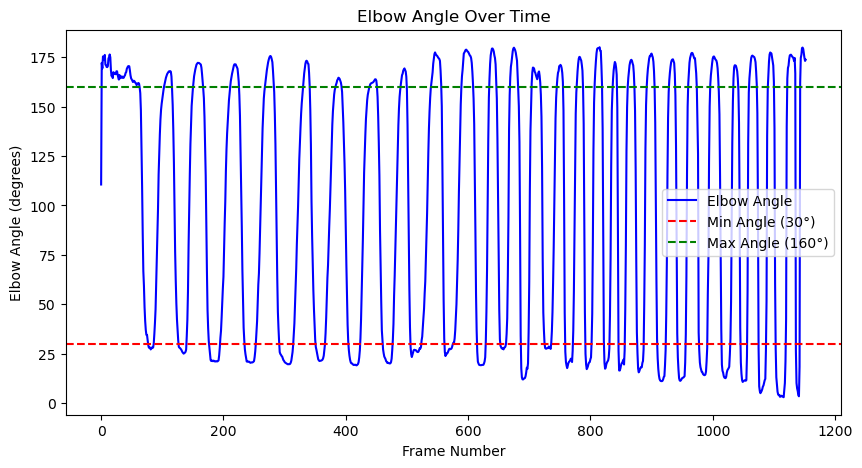

In [2]:
import matplotlib.pyplot as plt
# Angle Over Time Graph
plt.figure(figsize=(10, 5))
plt.plot(angle_data, label='Elbow Angle', color='blue')
plt.axhline(y=30, color='red', linestyle='--', label='Min Angle (30°)')
plt.axhline(y=160, color='green', linestyle='--', label='Max Angle (160°)')
plt.xlabel('Frame Number')
plt.ylabel('Elbow Angle (degrees)')
plt.title('Elbow Angle Over Time')
plt.legend()
plt.show()


## 2.Stability Histogram

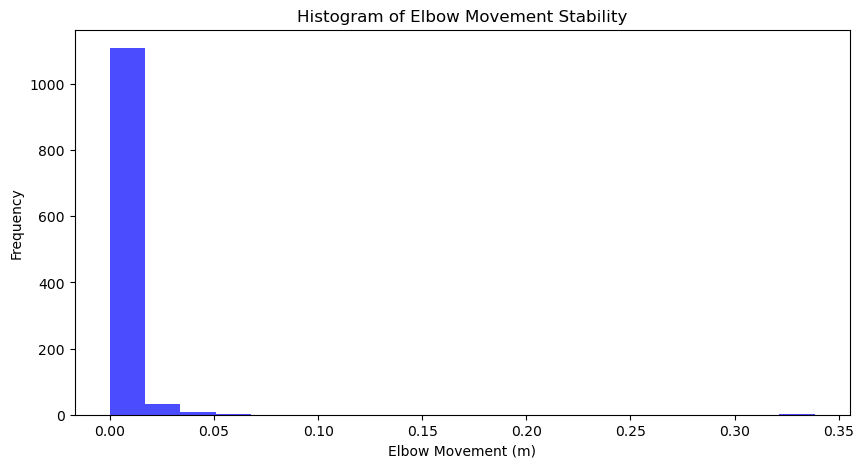

In [3]:
# Stability Histogram
plt.figure(figsize=(10, 5))
plt.hist(stability_data, bins=20, color='blue', alpha=0.7)
plt.xlabel('Elbow Movement (m)')
plt.ylabel('Frequency')
plt.title('Histogram of Elbow Movement Stability')
plt.show()


## 3.Scatter Plot of Angle vs. Stability

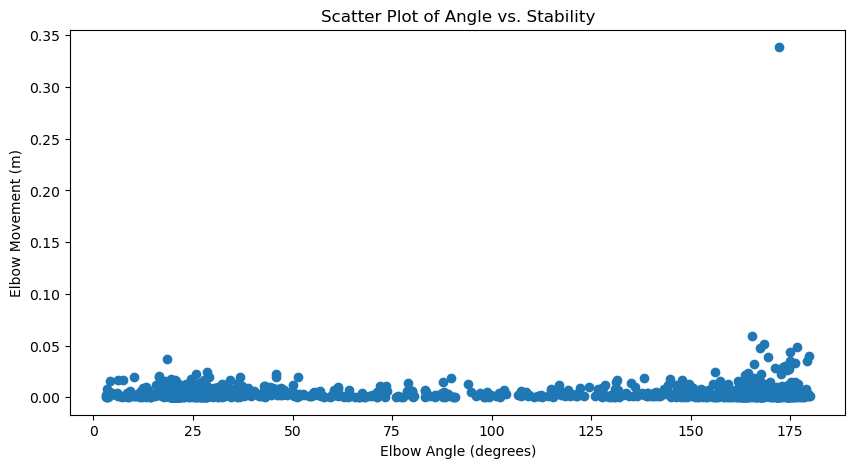

In [4]:
# Scatter Plot of Angle vs. Stability
plt.figure(figsize=(10, 5))
plt.scatter(angle_data, stability_data)
plt.xlabel('Elbow Angle (degrees)')
plt.ylabel('Elbow Movement (m)')
plt.title('Scatter Plot of Angle vs. Stability')
plt.show()
